## Second set of test runs - basic simulations, sparse fields where there is a mismeasurement of the PSFs (in terms of FWHM/shape/sigma).

Let's keep increasing the mismeasurement (percentage-wise) until we break ZOGY.

This is an updated of "26. algorithm shootout - detection-Copy5.ipynb

We now include bug fixes(?) to ZOGY-in-image-space, as well as have a better understanding of how to measure the "error" in the input PSFs (thanks to notebooks:<br>
"27. psf measurement evaluation - part 2" and<br>
"27. psf measurement evaluation - part 3".

Right now, ZOGY-in-image-space is slightly bad (see "27....part 3"). Let's get rid of that issue and just use normal ZOGY (all in FFT space).

At the bottom there is another shootout using "normal" ZOGY with and without a small amount of simulated scintillation. The scintillation helps ZOGY at slightly bad PSF fitting thresholds, but not to a great degree (at least for small, realistic amounts of scintillation).

Note that what I thought was 5-sigma sources (`SNR = 1500/300`) is actually more like 

`SNR = 1500 / sqrt(300 * PSF area) = 1500 / sqrt(300 * pi * 1.8 * 2.2) = 24.55`

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

# testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
#                          offset=[0,0], psf_yvary_factor=0., 
#                          #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
#                          varFlux2=[1500., 1500., 1500.],
#                          theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
#                          seed=66, psfSize=13)

# # Tweak the saved PSFs so the science PSF sigma is slightly wrong ("mis-measured"):
# P_n = testObj.im2.psf
# testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[2.2,1.8], theta=-35.)

# print dit.computeClippedImageStats(testObj.im1.im)
# print dit.computeClippedImageStats(testObj.im2.im)
# print dit.computeClippedImageStats(testObj.im1.var)
# print dit.computeClippedImageStats(testObj.im2.var)

# print np.sqrt(((P_n - testObj.im2.psf)**2.).mean())

# dit.plotImageGrid((P_n, testObj.im2.psf))

In [3]:
# psf = dit.makePsf(psfSize=13, sigma=[2.8*1.05,2.2*1.05], theta=-45.*1.05)
# print np.sqrt(((P_n - psf)**2.).mean())

def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a * psf2a   # instead of squaring either of them separately
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

# print computeNormedPsfRms(P_n, psf)

In [6]:
src = testObj.runTest(returnSources=True, zogyImageSpace=False)

In [7]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']:
    print key
    if key is not 'SZOGY':
        fsKey = 'base_PsfFlux_fluxSigma'
    else: # For SZOGY, the correct flux measurement is PeakLikelihoodFlux
        fsKey = 'base_PeakLikelihoodFlux_fluxSigma'
    print src[key][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', fsKey, 'base_PsfFlux_flag']]

[[  242.21750369   271.65070471     0.          1500.        ]
 [  278.50448812   278.77794277     0.          1500.        ]
 [  256.96791745   291.09644383     0.          1500.        ]]
ALstack
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            242.010610            271.017784              166.399371             False
1            278.167924            278.042427              166.917624             False
2            256.995223            291.092642              168.603719             False
ZOGY
    base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0             140.446638             46.575771              242.358769             False
1             387.366462             57.476490              217.113442             False
2             374.874972             90.842462              173.742035             False
4              57.291378            144.467898              270.097661             False


In [8]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varFlux2=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[2.2,1.8], theta=-35.)

det = testObj.runTest(zogyImageSpace=False)
print det

{'ZOGY': {'FP': 46, 'FN': 7, 'TP': 1}, 'ALstack': {'FP': 0, 'FN': 0, 'TP': 8}, 'SZOGY': {'FP': 24, 'FN': 7, 'TP': 1}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 8}}


Try some real tests!

In [21]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1, percentagePsfMismeasure=10.,
           scintillation=0., returnImages=False):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., scintillation=scintillation,
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13, avoidBorder=False)
    #testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.9,2.1], theta=-35.)
    ppm = 1.0 + percentagePsfMismeasure / 100.
    origPsf = testObj.im2.psf
    testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.8*ppm,2.2*ppm], theta=-45.*ppm)
    #if scintillation == 0:
    testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = scintillation
    det = testObj.runTest(zogyImageSpace=True) #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    det['ppm'] = percentagePsfMismeasure
    #det['rms'] = np.sqrt(((origPsf - testObj.im2.psf)**2.).mean())
    det['rms'] = computeNormedPsfRms(origPsf, testObj.im2.psf)
    if returnImages:
        det['testObj'] = testObj
    #print percentagePsfMismeasure, det['rms']
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

### Violin plots:
https://seaborn.github.io/generated/seaborn.violinplot.html#seaborn.violinplot

In [12]:
def plotResults(tr, methods=['ALstack', 'SZOGY']):
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})

    TP['rms'] = np.array([t['rms'] for t in tr])
    FP['rms'] = np.array([t['rms'] for t in tr])
    FN['rms'] = np.array([t['rms'] for t in tr])

    matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    tmp1 = TP[['rms', methods[0]]]
    tmp2 = TP[['rms', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
    tmp = pd.concat((tmp1, tmp2))
    tmp['rms'] = np.round(tmp['rms'], 3)  # make it RMS instead of RMS

    g = sns.violinplot(x='rms', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[0])
    g.set_title('True Positives')
    g.set_ylim((0, 50))
    g.set_xlabel('PSF measurement error')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

    tmp1 = FP[['rms', methods[0]]]
    tmp2 = FP[['rms', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
    tmp = pd.concat((tmp1, tmp2))
    tmp['rms'] = np.round(tmp['rms'], 3)

    g = sns.violinplot(x='rms', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[1], width=0.98)
    g.set_title('False Positives')
    g.set_ylim((0, 15))
    g.set_xlabel('PSF measurement error')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

## Look at detection rates for ~25-sigma sources.

Vary the "error" in PSF measurement from 0 to 20%.

In [6]:
#errorVals = [0,1,2,3,4,4.5,5,5.5,6,6.5,7,7.5,8,9,10,12,14,17,20]
errorVals =  [0,  2,  4,          6,          8,  10,   13,16,20]
inputs = [(f, seed, ppm) for f in [1500] for seed in np.arange(66, 166, 1) for ppm in errorVals]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=1000, n_varSources=50, \
                                                                      percentagePsfMismeasure=i[2]) \
                                                     for i in inputs)

900


[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 23.9min
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 75.1min
[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 177.4min
[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed: 300.7min
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 387.9min finished


In [14]:
testResults1[800]

{'ALstack': {'FN': 11, 'FP': 0, 'TP': 39},
 'ALstack_noDecorr': {'FN': 9, 'FP': 1, 'TP': 41},
 'SZOGY': {'FN': 44, 'FP': 277, 'TP': 6},
 'ZOGY': {'FN': 44, 'FP': 224, 'TP': 6},
 'flux': 1500,
 'ppm': 20,
 'rms': 0.091119653414640886}

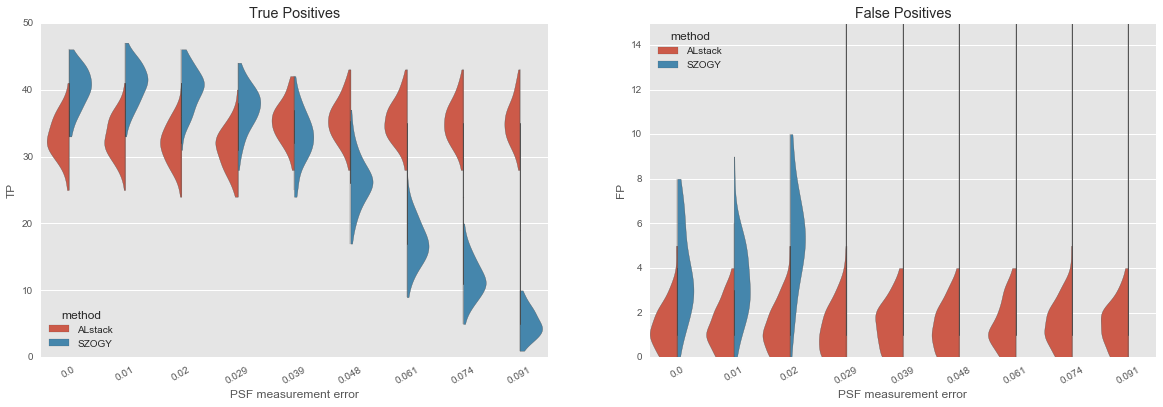

In [20]:
plotResults(testResults1, methods=['ALstack', 'SZOGY'])

In [7]:
import cPickle
import gzip
cPickle.dump((testResults1), gzip.GzipFile('testResults-28.p.gz', 'wb'))

## WTF? Looks correct.

In [18]:
reload(dit)
errVal = 2.
output = runTest(1500, 66, n_sources=1000, n_varSources=50, percentagePsfMismeasure=errVal,
                returnImages=True)
testObj = output.pop('testObj')
ret = testObj.doALInStack()

[0.0, 0.0]
{'rms': 0.0099637597685706958, 'SZOGY': {'FP': 3, 'FN': 11, 'TP': 38}, 'ALstack_noDecorr': {'FP': 0, 'FN': 16, 'TP': 33}, 'flux': 1500, 'ALstack': {'FP': 0, 'FN': 17, 'TP': 32}, 'ppm': 2.0, 'ZOGY': {'FP': 17, 'FN': 11, 'TP': 38}}


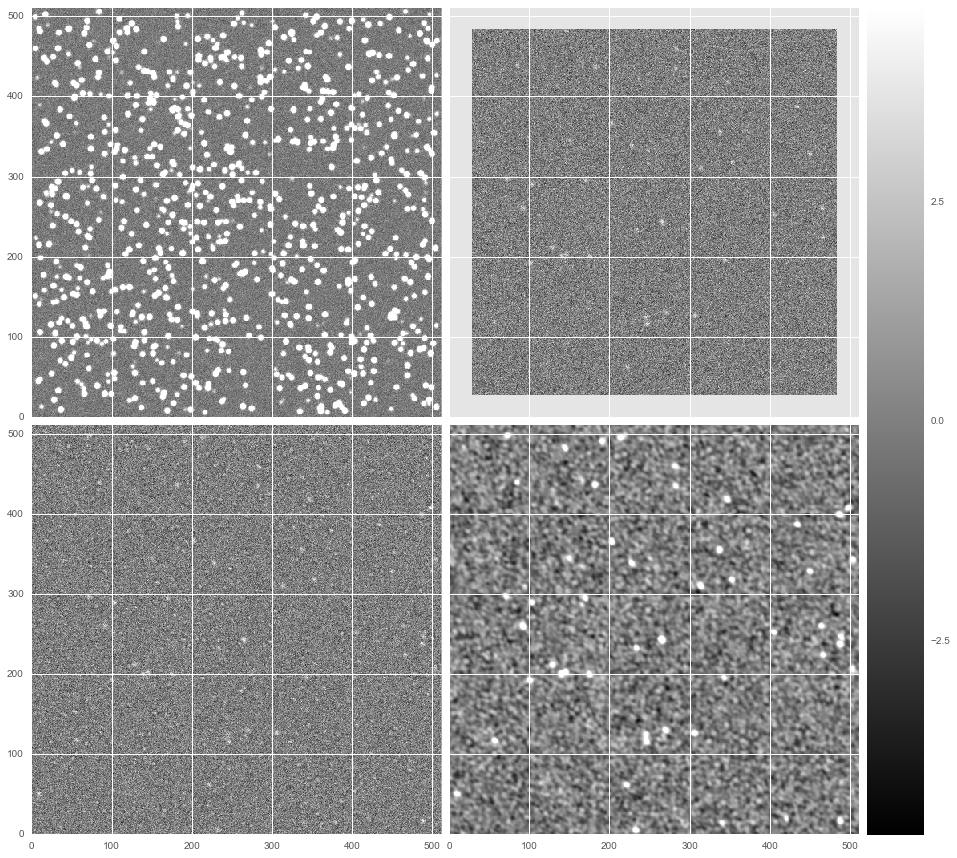

In [19]:
print testObj.astrometricOffsets
print output
fig = plt.figure(1, (16, 16))
dit.plotImageGrid((testObj.im1.im, ret.decorrelatedDiffim, 
                   testObj.D_ZOGY.im, testObj.S_corr_ZOGY.im))

In [92]:
src_ZOGY = dit.doDetection(testObj.D_ZOGY.asAfwExposure())
src_ZOGY = src_ZOGY[~src_ZOGY['base_PsfFlux_flag']]
print src_ZOGY.shape

src_SZOGY = dit.doDetection(testObj.S_corr_ZOGY.asAfwExposure(), doSmooth=False)
src_SZOGY = src_SZOGY[~src_SZOGY['base_PsfFlux_flag']]
print src_SZOGY.shape

(54, 140)
(27, 140)


In [93]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
#changedCentroid

In [94]:
dist = np.sqrt(np.add.outer(src_SZOGY.base_NaiveCentroid_x, -changedCentroid[:, 0])**2. + \
               np.add.outer(src_SZOGY.base_NaiveCentroid_y, -changedCentroid[:, 1])**2.)
matches = np.where(dist <= 1.5)
true_pos = len(np.unique(matches[0]))
false_neg = changedCentroid.shape[0] - len(np.unique(matches[1]))
false_pos = src_SZOGY.shape[0] - len(np.unique(matches[0]))
detections = {'TP': true_pos, 'FN': false_neg, 'FP': false_pos}
detections

{'FN': 1, 'FP': 18, 'TP': 9}

## See if a little scintillation helps ZOGY...

Say astrometric noise is ~10 milliarcsec = 0.01 arcsec. LSST has a pixel scale of 0.2 arcsec/pixel. So this would be a scintillation noise of ~0.05 pixels.

In [22]:
reload(dit)
errVal = 6.
output = runTest(1500, 66, n_sources=1000, n_varSources=50, percentagePsfMismeasure=errVal,
                returnImages=True, scintillation=0.05)
testObj = output.pop('testObj')
ret = testObj.doALInStack()

[0.05, 0.05] 0.316227766017
{'rms': 0.029304678293694125, 'SZOGY': {'FP': 68, 'FN': 18, 'TP': 31}, 'ALstack_noDecorr': {'FP': 13, 'FN': 18, 'TP': 31}, 'flux': 1500, 'ALstack': {'FP': 7, 'FN': 20, 'TP': 29}, 'ppm': 6.0, 'ZOGY': {'FP': 269, 'FN': 32, 'TP': 17}}


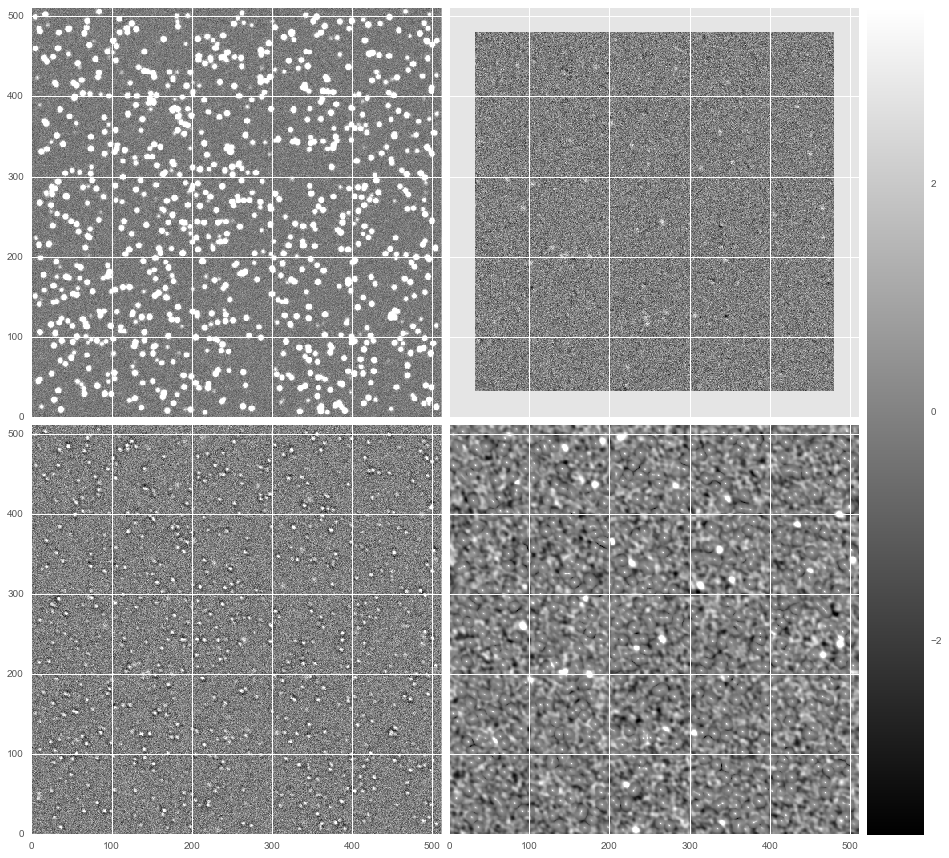

In [23]:
print testObj.astrometricOffsets, np.sqrt(np.sum(testObj.astrometricOffsets))
print output
fig = plt.figure(1, (16, 16))
dit.plotImageGrid((testObj.im1.im, ret.decorrelatedDiffim, 
                   testObj.D_ZOGY.im, testObj.S_corr_ZOGY.im))

In [134]:
src_ZOGY = dit.doDetection(testObj.D_ZOGY.asAfwExposure())
src_ZOGY = src_ZOGY[~src_ZOGY['base_PsfFlux_flag']]
print src_ZOGY.shape

src_SZOGY = dit.doDetection(testObj.S_corr_ZOGY.asAfwExposure(), doSmooth=False)
src_SZOGY = src_SZOGY[~src_SZOGY['base_PsfFlux_flag']]
print src_SZOGY.shape

(55, 140)
(12, 140)


In [135]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
#changedCentroid

In [136]:
dist = np.sqrt(np.add.outer(src_SZOGY.base_NaiveCentroid_x, -changedCentroid[:, 0])**2. + \
               np.add.outer(src_SZOGY.base_NaiveCentroid_y, -changedCentroid[:, 1])**2.)
matches = np.where(dist <= 1.5)
true_pos = len(np.unique(matches[0]))
false_neg = changedCentroid.shape[0] - len(np.unique(matches[1]))
false_pos = src_SZOGY.shape[0] - len(np.unique(matches[0]))
detections = {'TP': true_pos, 'FN': false_neg, 'FP': false_pos}
detections

{'FN': 1, 'FP': 3, 'TP': 9}

In [137]:
#errorVals = [0,1,2,3,4,4.5,5,5.5,6,6.5,7,7.5,8,9,10,12,14,17,20]
errorVals =  [0,  2,  4,          6,          8,  10,   13,16,20]
inputs = [(f, seed, ppm) for f in [1500] for seed in np.arange(66, 166, 1) for ppm in errorVals]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=1000, n_varSources=50, \
                                                                      percentagePsfMismeasure=i[2], \
                                                                      scintillation=0.05) \
                                                     for i in inputs)

900


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 17.0min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 31.0min
[Parallel(n_jobs=3)]: Done 900 out of 900 | elapsed: 43.3min finished


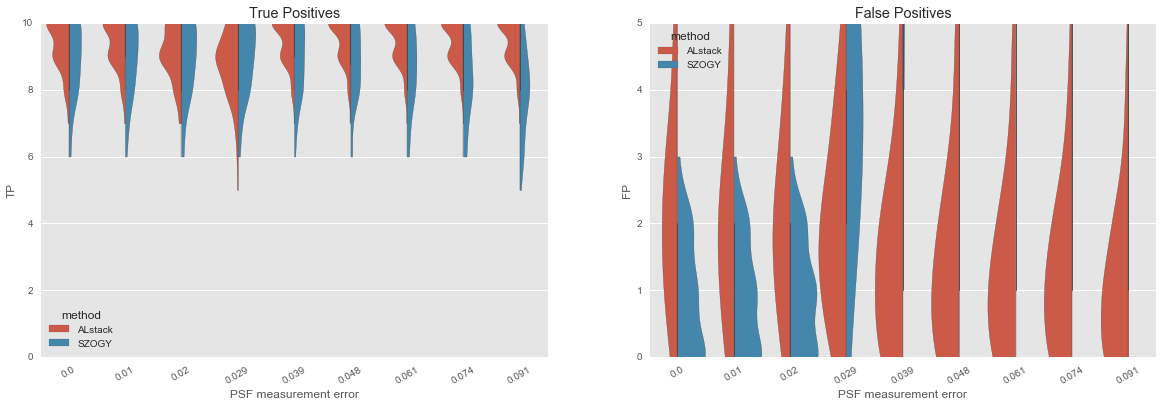

In [138]:
plotResults(testResults2)

In [139]:
import cPickle
import gzip
cPickle.dump((testResults1, testResults2), gzip.GzipFile('testResults-28.p.gz', 'wb'))